In [1]:
from micrograd.engine import Value
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import Image, display

/tmp/ipykernel_38094/3515724521.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)

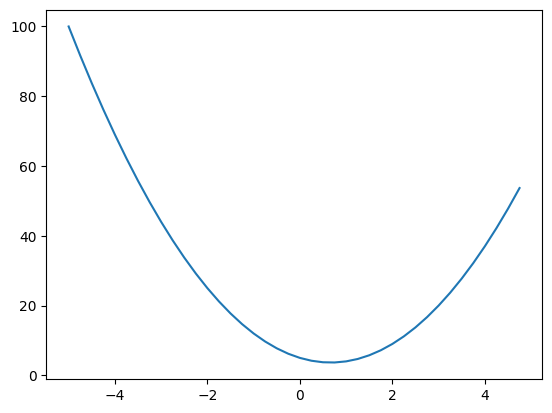

In [6]:
 plt.plot(xs, ys)
plt.show()

In [7]:
h = 0.000000000000001
x = 3.0 
f(x)

20.0

In [8]:
(f(x+h) - f(x))/h

10.658141036401503

In [9]:
h = 0.0001

#inputs

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope: ', (d2-d1)/h)


d1 4.0
d2 4.0002
slope:  2.0000000000042206


In [10]:
a = Value(2.0)
b = Value(-3.0)


In [11]:
class Value:
    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(label={self.label} | data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rmul__(self, other):
        return self * other  
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += out.grad * other* (self.data**(other-1))
        out._backward = _backward
        return out
    
    
    def __truediv__(self, other):
        return self*other**-1
    
    def tanh(self):
        n = self.data
        tanh = (math.exp(2*n) - 1)/(math.exp(2*n)+1)
        out = Value(tanh, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1- tanh**2)*out.grad
        out._backward = _backward
        return out


    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            



In [12]:
a = Value(2.0)
b = Value(4.0)

a-b

Value(label= | data=-2.0)

In [13]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [14]:
def lol():
    h = 0.0001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label ='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label ='d'
    f = Value(-2.0 + h , label='f')
    L = d * f; L.label = 'L'
    L2 = L

    print((L2.data-L1.data)/h)


In [15]:
#inputs x1 and x2

x1 = Value(2.0, label='x1')

x2 = Value(0.0, label='x2')


# weights w1 and w2
w1 = Value(-3.0, label='w1')

w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813, label='b')

x1w1 = x1 * w1;  x1w1.label = 'x1*w1'

x2w2 = x2 * w2; x2w2.label = 'x2*w2'


x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

    
o = n.tanh(); o.label = 'o'

In [16]:
o.backward()

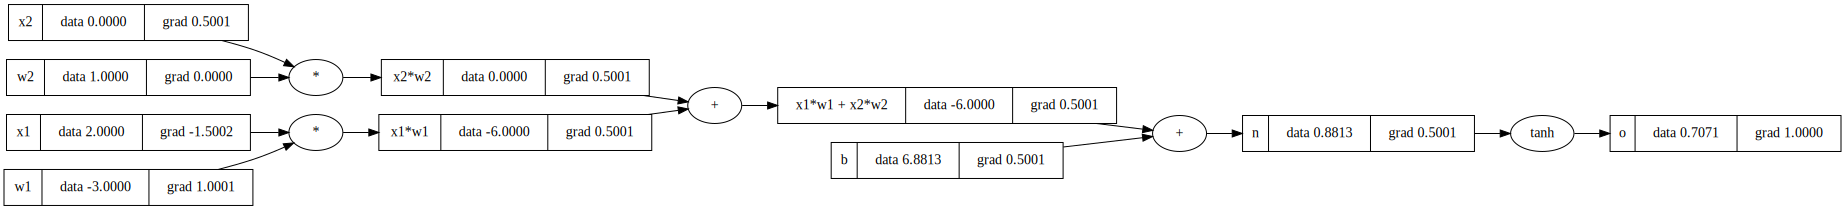

In [17]:
draw_dot(o)

In [18]:
#inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')


# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813, label='b')
x1w1 = x1 * w1;  x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

#o = n.tanh(); o.label = 'o'


o = ((2*n).exp() - 1)/((2*n).exp() +1); o.label='o'


o.backward()

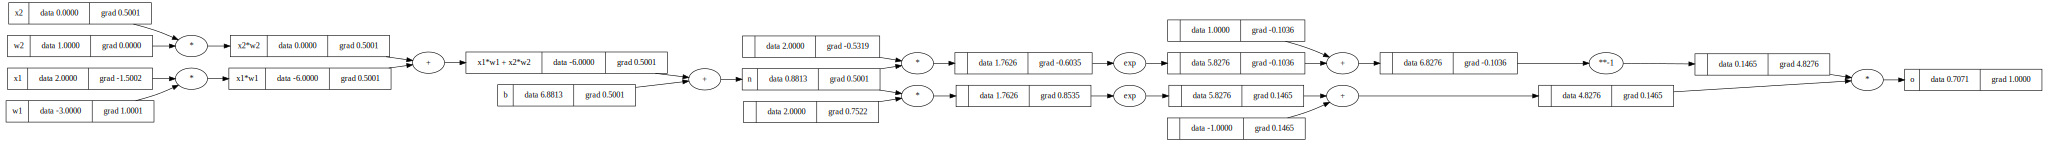

In [19]:
draw_dot(o)

In [20]:
o.grad = 1.0 

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()


In [21]:
topo = []

visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
topo

[Value(label= | data=-1),
 Value(label=x1 | data=2.0),
 Value(label=w1 | data=-3.0),
 Value(label=x1*w1 | data=-6.0),
 Value(label=w2 | data=1.0),
 Value(label=x2 | data=0.0),
 Value(label=x2*w2 | data=0.0),
 Value(label=x1*w1 + x2*w2 | data=-6.0),
 Value(label=b | data=6.8813),
 Value(label=n | data=0.8813000000000004),
 Value(label= | data=2),
 Value(label= | data=1.7626000000000008),
 Value(label= | data=5.8275693947040725),
 Value(label= | data=4.8275693947040725),
 Value(label= | data=1),
 Value(label= | data=2),
 Value(label= | data=1.7626000000000008),
 Value(label= | data=5.8275693947040725),
 Value(label= | data=6.8275693947040725),
 Value(label= | data=0.14646500711888305),
 Value(label=o | data=0.7070699857622339)]

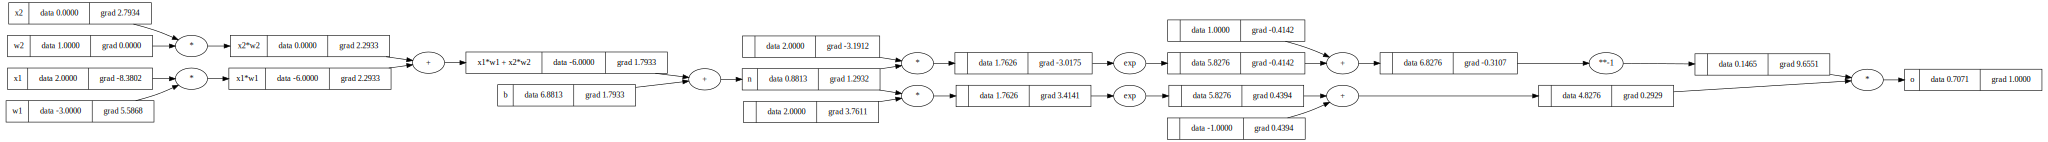

In [22]:
draw_dot(o)

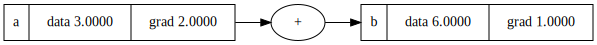

In [23]:
a = Value(3.0, label='a')
b = a + a; b.label='b'

b.backward()
draw_dot(b)

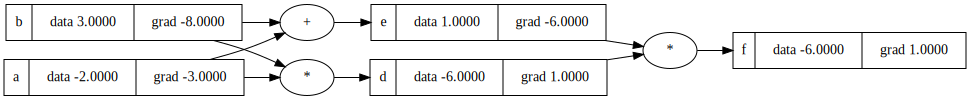

In [24]:
a = Value(-2.0, label='a')
b = Value(3.0, label = 'b')

d = a*b; d.label='d'
e = a + b; e.label='e'
f = d*e; f.label='f'

f.backward()
draw_dot(f)

In [25]:
import torch
import random

In [26]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad=True

2

In [27]:
x2 = torch.Tensor([0.0]).double();  x2.requires_grad=True

In [28]:
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad=True


b = torch.Tensor([6.88137]).double(); b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)


print(o.data.item())
o.backward()

print("----")

print("x2", x2.grad.item())
print("w", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())



0.7071050214706146
----
x2 0.5000024886110417
w 0.0
x1 -1.500007465833125
w1 1.0000049772220834


In [29]:
o.item()

0.7071050214706146

In [32]:
class Neuron:
    """
    A single neuron = 1 computational unit.

    - Takes a vector input of shape (1 × nin)
    - Has:
        - nin weights (one for each input)
        - 1 bias
        - 1 activation function (tanh)

    - Produces 1 scalar output: tanh(w · x + b)

    Each neuron responds differently to the same input due to its unique weight vector.
    """

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # Weighted sum + bias
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        # Activation function (non-linearity)
        return act.tanh()


class Layer:
    """
    A Layer is a collection of neurons.

    - Input: a vector of shape (1 × nin)
    - Contains: nout neurons
        - Each neuron receives the full input vector
        - Each produces 1 scalar output
    - Output: a vector of shape (1 × nout)
    """

    def __init__(self, nin, nout):
        # Each neuron has its own weights, but all share the same input
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        # Feed input to each neuron
        outs = [n(x) for n in self.neurons]
        # If only one neuron, return scalar instead of list
        return outs[0] if len(outs) == 1 else outs


class MLP:
    """
    Multi-Layer Perceptron (MLP)

    - Built as a sequence of layers
    - Architecture is defined by:
        nin   → number of input features
        nouts → list of layer widths (e.g., [4, 4, 1] = 2 hidden + 1 output)

    Example:
        MLP(3, [4, 4, 1])
        builds:
          Layer(3 → 4)
          Layer(4 → 4)
          Layer(4 → 1)
    """

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        # Forward pass: pipe x through each layer
        for layer in self.layers:
            x = layer(x)
        return x


In [31]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]]

ys = [1.0, -1.0, -1.0, 1.0] #desired targets 

ypred = [n(x) for x in xs]
ypred

[Value(label= | data=0.9979514309621139),
 Value(label= | data=0.9982132582137067),
 Value(label= | data=0.921007796247389),
 Value(label= | data=0.998165222424028)]

In [53]:
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0,()))
loss

Value(label= | data=5.019279765610715)

In [54]:
loss.backward()

In [55]:
n.layers[0].neurons[0].w[0].grad

-1.478310026330606

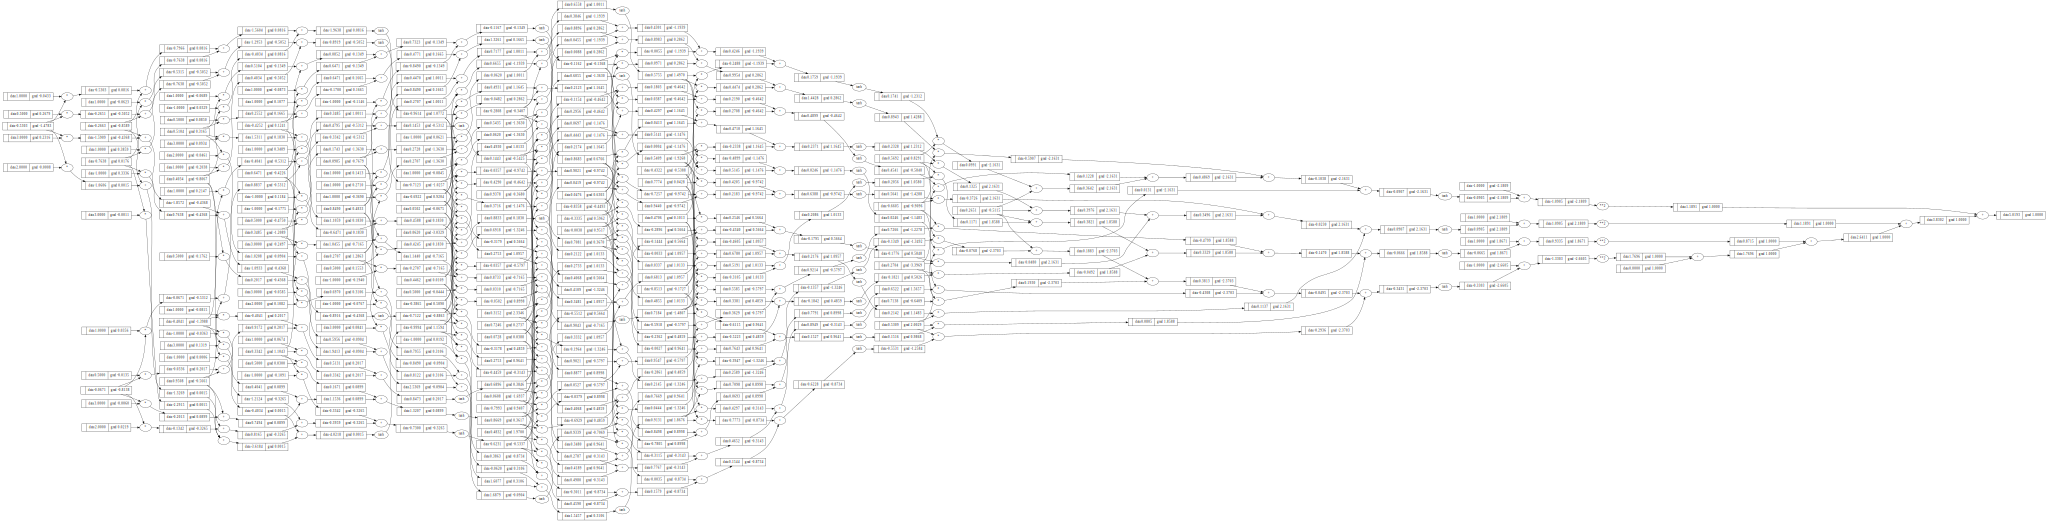

In [56]:
draw_dot(loss)